# Data loading and cleaning

In [2]:
# load the audio files, and give each noise a label
# we'll assume each file contains multiple, spaced reptitions of the same noise
from pydub import AudioSegment
directory = "./recordings/sennheiser/"
noise_audio = {
    't': AudioSegment.from_file(directory + 't1.m4a'),
    'p': AudioSegment.from_file(directory + 'p1.m4a')
}

# get some basic properties
frame_rate = { n: noise_audio[n].frame_rate for n in noise_audio }
print("Frame rates:", frame_rate)
# print(noise_t_audio.duration_seconds)
# print(noise_t_audio.duration_seconds * noise_t_audio.frame_rate == noise_t_audio.frame_count())
# print(noise_t_audio.sample_width)
# print(noise_t_audio.channels)

# convert to mono, so each frame has only one sample
noise_audio_mono = { n: noise_audio[n].set_channels(1) for n in noise_audio }

# finally, convert to a more workable data type
import pandas as pd
noise_sample_array = {n: noise_audio_mono[n].get_array_of_samples() for n in noise_audio }
noise_series = { n: pd.Series(noise_sample_array[n], name=n) for n in noise_audio }

noises = pd.concat(noise_series.values(), axis=1)

Frame rates: {'t': 44100, 'p': 44100}


In [3]:
# We may need these later
import numpy as np
import matplotlib.pyplot as plt

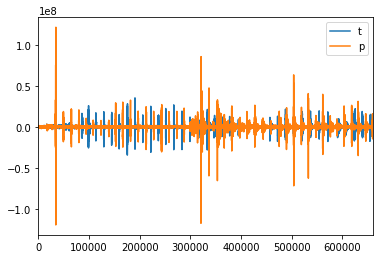

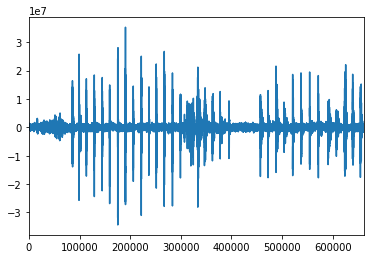

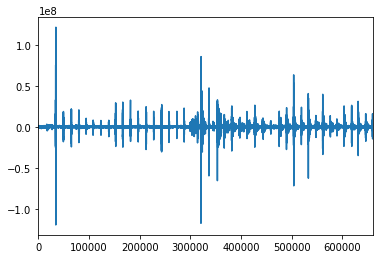

In [54]:
# visualize, to make sure things are sensible so far
length = 15 * frame_rate['t']
noises[:length].plot()
plt.figure()
noises['t'][:length].plot()
plt.figure()
noises['p'][:length].plot()

Zooming in on a couple representative spikes, we see they
* are quite distinct, 
* begin abruptly, and 
* last <~ 3000 frames ~ 0.07s

Duration shown: 0.22675736961451248
Duration shown: 0.22675736961451248


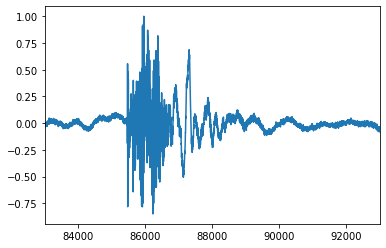

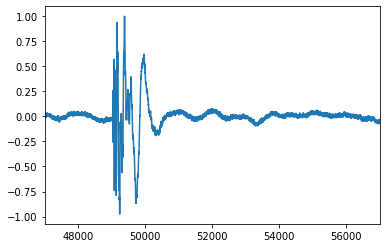

In [103]:
start    = 83000
duration = 10000
t_example = noises['t'][start:start+duration]
t_example /= t_example.apply(abs).max()
t_example.plot()
print("Duration shown:", duration / frame_rate['t'])

# play the sample. sounddevice is easier to use than pydub for this
import sounddevice as sd
data = t_example / 10
sd.play(data, fs)
sd.wait()

start    = 47000
duration = 10000

plt.figure()
p_example = noises['p'][start:start+duration]
p_example /= p_example.max()
p_example.plot()
print("Duration shown:", duration / frame_rate['t'])

data = p_example / 10
sd.play(data, fs)

We want to isolate each of these spikes from the recording automatically, as individual "observations" of the desired noise. To do so we need to estimate when each noise starts, and how long it lasts. We'll assume short, percussive noises for now (not drawn out, like a hisssss).

{'t': 7054231.2, 'p': 32285209.6}


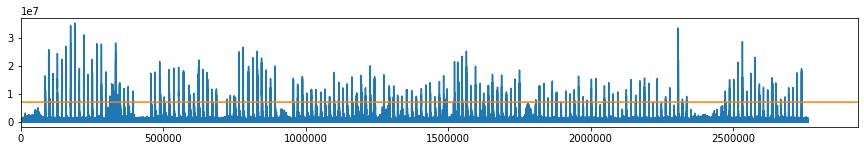

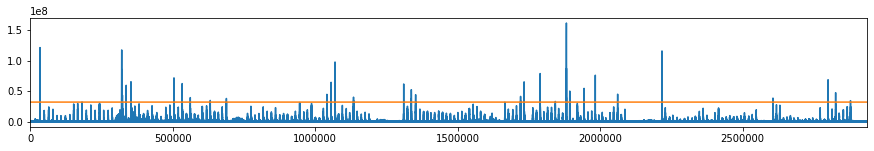

In [98]:
# To isolate the spikes, look for points with (absolute value) at least 20% of the maximum (absolute value)
SPIKE_THRESHOLD_FRACTION = .20
noises_abs = noises.apply(abs)
spike_thresholds = { n: noises_abs[n].max() * SPIKE_THRESHOLD_FRACTION for n in noises }
print(spike_thresholds)

# How does this look?


for n in noises:
    plt.figure(figsize=(15,2))
    noises_abs[n].plot()
    
    x = range(len(noises))
    yval = spike_thresholds[n]
    plt.plot(x, [yval] * len(x), label=n)

It seems to catch most of them for 't', but misses a lot of them for 'p'. Looking in terms of dB isn't much more enlightening:

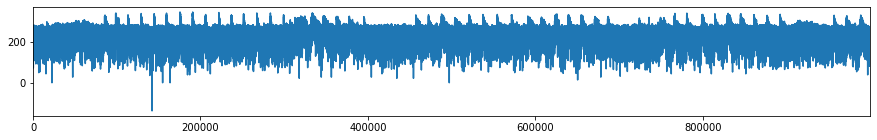

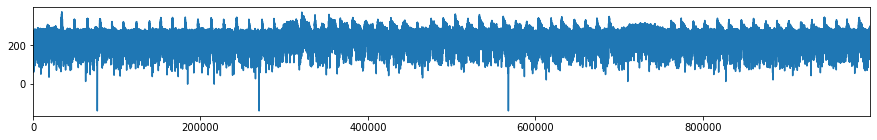

In [115]:
noises_abs_dB = noises.apply(lambda x: 20 * np.log(abs(x) + 0.001))

start = 0
end   = 10**6
for n in noises:
    plt.figure(figsize=(15,2))
    noises_abs_dB[n][start:end].plot()

To find the spikes, then, let's scan and look for peaks in amplitude. We observed earlier that each spike lasts a few 10s of ms, so let's scan in batches of ~0.02 sec, looking for with the amplitude in one batch is substantially larger than the previous. This should also help to avoid loud but non-percussive noises (like a breath or word) that might otherwise clutter the data.

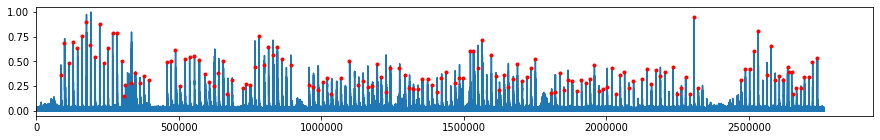

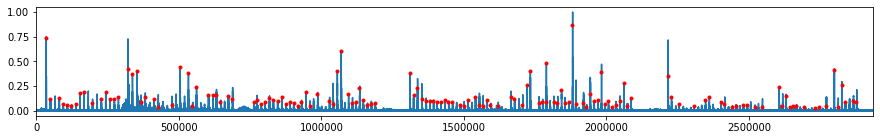

In [163]:
BATCH_DURATION = 0.02 # look at BATCH_DURATION (seconds) at a time
THRESHOLD_MULTIPLIER = 5 # detect a spike when the next batch is at least THRESHOLD_MULTIPLIER times bigger

spike_locations  = { n: [] for n in noises }
batch_amplitudes = { n: [] for n in noises }
spike_amplitudes = { n: [] for n in noises }
for n in noises:
    data  = noises[n].apply(abs)
    data /= data.max() # normalize
    batch_size = round(BATCH_DURATION * frame_rate[n])
    number_of_batches = len(data) // batch_size
    
    last_amplitude = 1 # initialize variable
    for b in range(number_of_batches):
        start = batch_size * b
        end   = batch_size * (b + 1)
        amplitude = data[start:end].max()
#         batch_amplitudes[n].append(amplitude)
        if amplitude > THRESHOLD_MULTIPLIER * last_amplitude:
            spike_locations[n].append(start)
            spike_amplitudes[n].append(amplitude)
        last_amplitude = amplitude
    
    # visualize the spike locations
    plt.figure(figsize=(15,2))
    data.plot()
    for i in range(len(spike_locations[n])):
        x = spike_locations[n][i]
        y = spike_amplitudes[n][i]
        plt.plot([x], [y], marker='o', markersize=3, color="red")


At least by visual inspection, this seems to have caught most volume spikes relatively well. Let's now grab a window around each spike, that we'll use for analysis and training. This will create one dataframe per isolated noise. We'll also normalize them while we're at it, to have the same average amplitude.

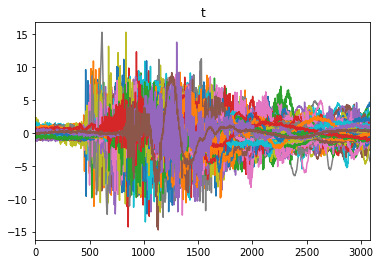

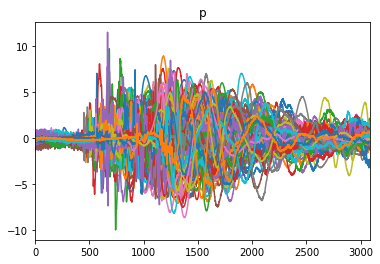

In [172]:
BEFORE = 0.5 * BATCH_DURATION # the time (sec) to look before the spike location
AFTER  = 3 * BATCH_DURATION # the time (sec) to look after the spike location

noises_isolated = {}

def normalize(series):
    mean = series.apply(abs).mean()
    return series / mean

for n in noises:
    df = pd.DataFrame()
    b = round(BEFORE * frame_rate[n])
    a = round(AFTER  * frame_rate[n])
    LABEL = '_obs'
    for s in spike_locations[n]:
        obs = noises[n].iloc[ s-b : s+a ].reset_index(drop=True)
        df[n + LABEL + str(s)] = normalize(obs)
    
    noises_isolated[n] = df
    noises_isolated[n].plot(legend=False, title=n)

These observations are all the same length, and have no missing data. This is dependent on two things: 
* the before and after intervals were identical because the frame rates were identical (different frame rates might yield off by one differences because of rounding)
* the spikes are all sufficiently displaced from the ends of the data that there is always enough data to grab a full before and after interval

The former we could control by matching all the frame rates before proceeding. The latter will be important for training anyways, so we can instruct users to leave enough quiet space at the beginning and ends of the recordings. This will not be hard, because we only need 32ms per observation.

In [173]:
# There is no missing data
[ noises_isolated[n].isnull().any().any() for n in noises ]

[False, False]

Let's listen to the samples, to see if they sound reasonable. They generally sound pretty good, though the 'p' noise seems often dominated by air blowing into the microphone rather than the lip pop itself. That will likely vary quite a bit based on the microphone and microphone position used, so we should keep an eye on this.

In [ ]:
for n in noises:
    fs = frame_rate[n]
    for obs_label, obs_data in noises_isolated[n].iteritems():
        obs_data /= 10
        sd.play(obs_data, fs)
        sd.wait()

# Classification

To classify these, we will compute their spectrograms and classify the resulting images. To begin, we will use MFCC for the spectrograms, and a Convolutional Neural Net (CNN) to classify them, since CNN's have shown particular success in image classification. We will use PyTorch for both of these tasks. (Ultimately we might wish to use PyTorch for the original audio processing, as well.)

In [187]:
import torch
import torchaudio
import matplotlib.pyplot as plt

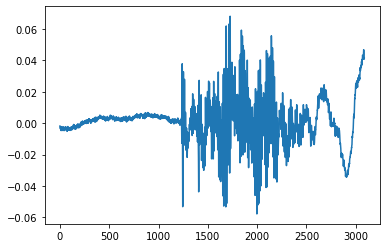

In [191]:
t = torch.tensor(noises_isolated['t'].iloc[:,0])
p = torch.tensor(noises_isolated['p'].iloc[:,0])
tfull = torch.tensor(noises['t'], dtype=torch.float)
pfull = torch.tensor(noises['p'], dtype=torch.float)

plt.plot(t.numpy())

In [85]:
print(t)
print(tfull)

tensor([ 0.0116,  0.0135,  0.0526,  ...,  0.1124,  0.1969, -0.1308])
tensor([129., 210., 114.,  ...,   1.,  -1.,   0.])


Shape of spectrogram: torch.Size([128, 8])


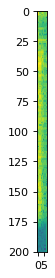

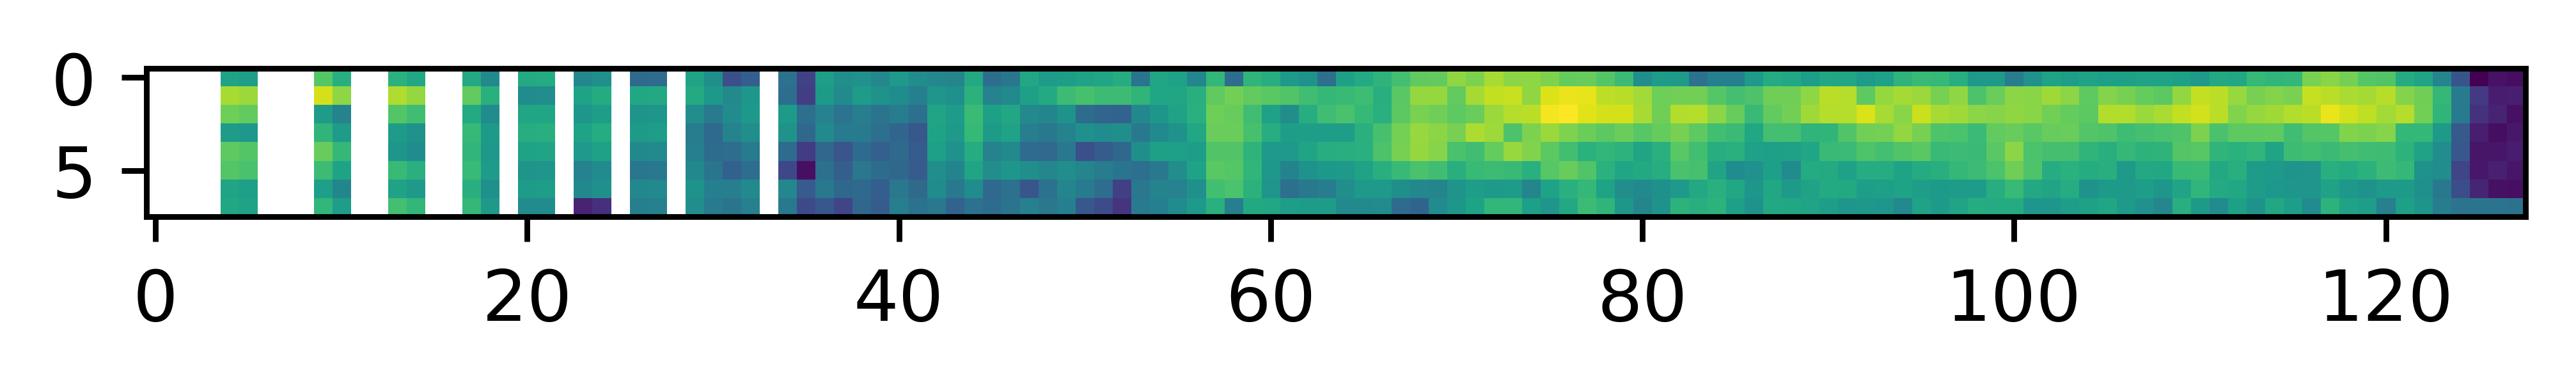

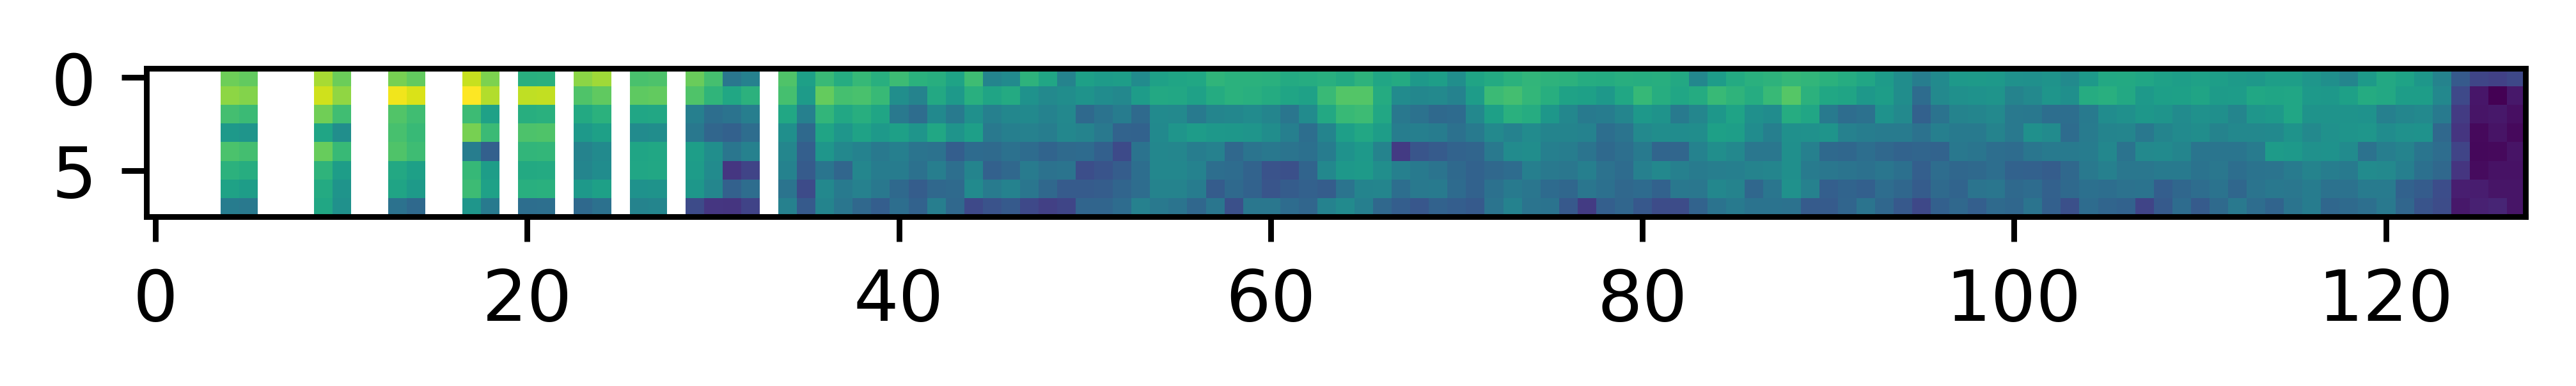

In [156]:
# specgram = torchaudio.transforms.MFCC(
#     sample_rate=frame_rate['t'],
#     n_fft=50
# )(t)
specgram = torchaudio.transforms.Spectrogram()(t)
specgram.size()

specgram_mel = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(t)
specgram.size()


print("Shape of spectrogram: {}".format(specgram_mel.size()))


plt.figure(dpi=80)
plt.imshow(specgram.log2().numpy())

plt.figure(dpi=800)
plt.imshow(torch.t(specgram_mel.log2()).numpy())


specgram_mel = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(p)
specgram.size()
plt.figure(dpi=800)
plt.imshow(torch.t(specgram_mel.log2()).numpy())



In [99]:
torchaudio.transforms.MFCC(
    sample_rate=frame_rate['t'],
)(tfull).size()

torch.Size([40, 1715])

In [102]:
filename = 'laptop_mic_t.wav'
waveform, sample_rate = torchaudio.load(filename)

Shape of spectrogram: torch.Size([2, 201, 1715])


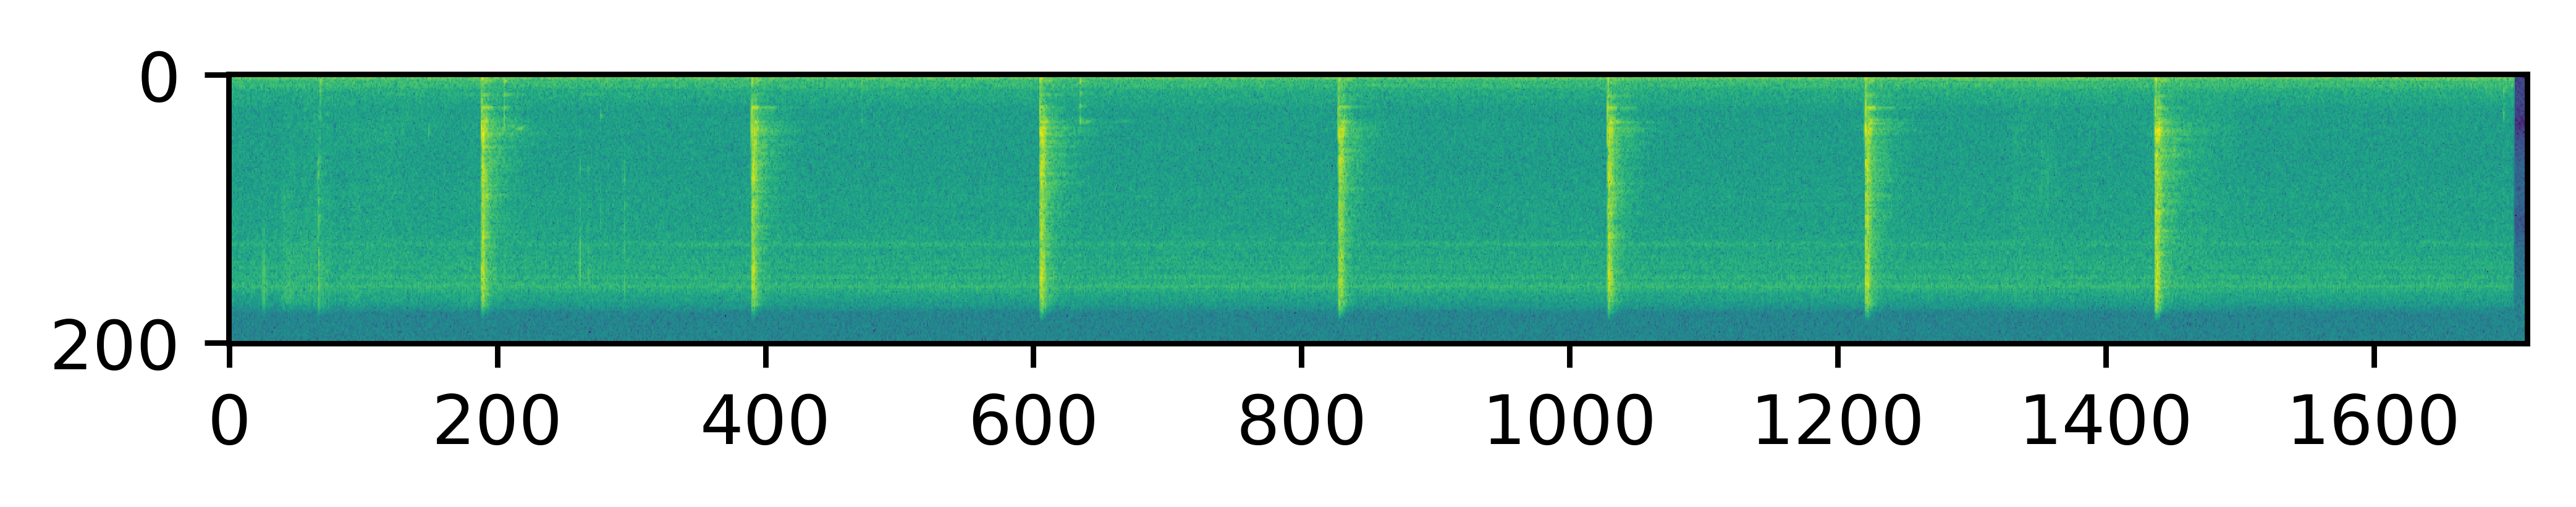

In [137]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(dpi=800)
p = plt.imshow(specgram.log2()[0,:,:].numpy())

Shape of spectrogram: torch.Size([128, 1715])


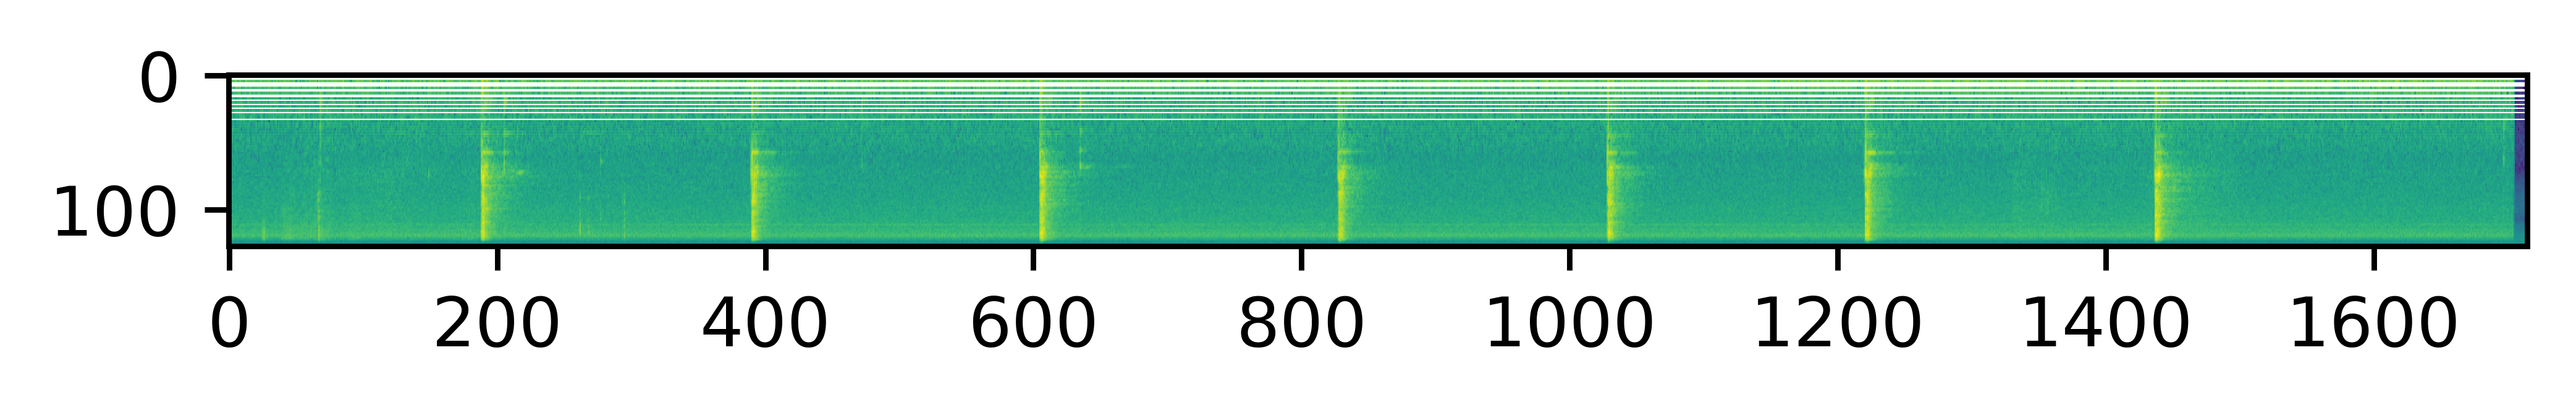

In [135]:
specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(waveform[0])

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(dpi=800)
p = plt.imshow(specgram.log2()[:,:].numpy())

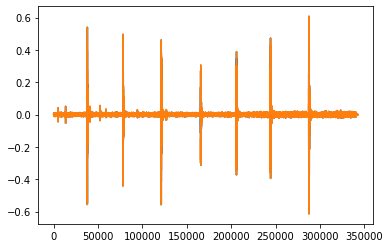

In [109]:
plt.plot(waveform.t().numpy())

In [108]:
tfull

tensor([129., 210., 114.,  ...,   1.,  -1.,   0.])

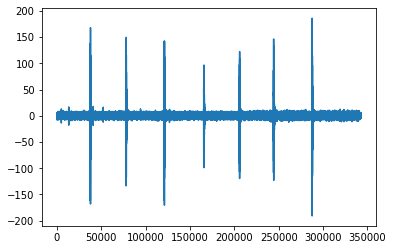

In [123]:
difference = waveform[1] * 129 / 0.0039 - tfull
plt.plot(difference.numpy())

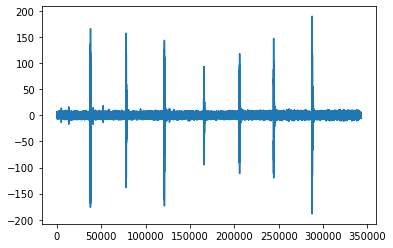

In [134]:
sample_rate

44100